# Forecasting number of Covid-19 cases in Georgia

This notebook implements time series forecasting using Tensorflow to predict number of Covid-19 positive cases in Georgia.

# Download, analyze and prepare data

Covid-19 public dataset by Cameron Appel, Diana Beltekian, Daniel Gavrilov, Charlie Giattino, Joe Hasell, Bobbie Macdonald, Edouard Mathieu, Esteban Ortiz-Ospina, Hannah Ritchie, Lucas Rodés-Guirao, Max Roser.

https://github.com/owid/covid-19-data/tree/master/public/data

In [199]:
!wget https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv

--2021-11-03 07:38:50--  https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35185925 (34M) [text/plain]
Saving to: ‘owid-covid-data.csv.2’

owid-covid-data.csv 100%[===================>]  33.56M  62.3MB/s    in 0.5s    

2021-11-03 07:38:51 (62.3 MB/s) - ‘owid-covid-data.csv.2’ saved [35185925/35185925]



In [200]:
# read data as a pandas dataframe
import pandas as pd

df = pd.read_csv("/content/owid-covid-data.csv")
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [201]:
# dataframe contains data from every country, let's extract only Georgia
df = df[df["location"] == "Georgia"]

In [202]:
df.head(5)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
43355,GEO,Asia,Georgia,2020-02-26,1.0,1.0,NaN,NaN,NaN,NaN,0.251,0.251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.44,3979773.0,65.032,38.7,14.864,10.244,9745.079,4.2,496.218,7.11,5.3,55.5,NaN,2.6,73.77,0.812,NaN,NaN,NaN,NaN
43356,GEO,Asia,Georgia,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,0.251,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.44,3979773.0,65.032,38.7,14.864,10.244,9745.079,4.2,496.218,7.11,5.3,55.5,NaN,2.6,73.77,0.812,NaN,NaN,NaN,NaN
43357,GEO,Asia,Georgia,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,0.251,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.44,3979773.0,65.032,38.7,14.864,10.244,9745.079,4.2,496.218,7.11,5.3,55.5,NaN,2.6,73.77,0.812,NaN,NaN,NaN,NaN
43358,GEO,Asia,Georgia,2020-02-29,1.0,0.0,NaN,NaN,NaN,NaN,0.251,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.44,3979773.0,65.032,38.7,14.864,10.244,9745.079,4.2,496.218,7.11,5.3,55.5,NaN,2.6,73.77,0.812,304.8,3.6,6.72,76.587283
43359,GEO,Asia,Georgia,2020-03-01,3.0,2.0,NaN,NaN,NaN,NaN,0.754,0.503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.56,3979773.0,65.032,38.7,14.864,10.244,9745.079,4.2,496.218,7.11,5.3,55.5,NaN,2.6,73.77,0.812,NaN,NaN,NaN,NaN


In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 615 entries, 43355 to 43969
Data columns (total 65 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   iso_code                                 615 non-null    object 
 1   continent                                615 non-null    object 
 2   location                                 615 non-null    object 
 3   date                                     615 non-null    object 
 4   total_cases                              615 non-null    float64
 5   new_cases                                615 non-null    float64
 6   new_cases_smoothed                       610 non-null    float64
 7   total_deaths                             577 non-null    float64
 8   new_deaths                               577 non-null    float64
 9   new_deaths_smoothed                      610 non-null    float64
 10  total_cases_per_million                  615

In [204]:
# let's extract date and new cases columns
import datetime

date = pd.to_datetime(df["date"], format = "%Y-%m-%d")  # convert string to datetime format
date = date.dt.date
date = date.values
new_cases = df["new_cases"].values

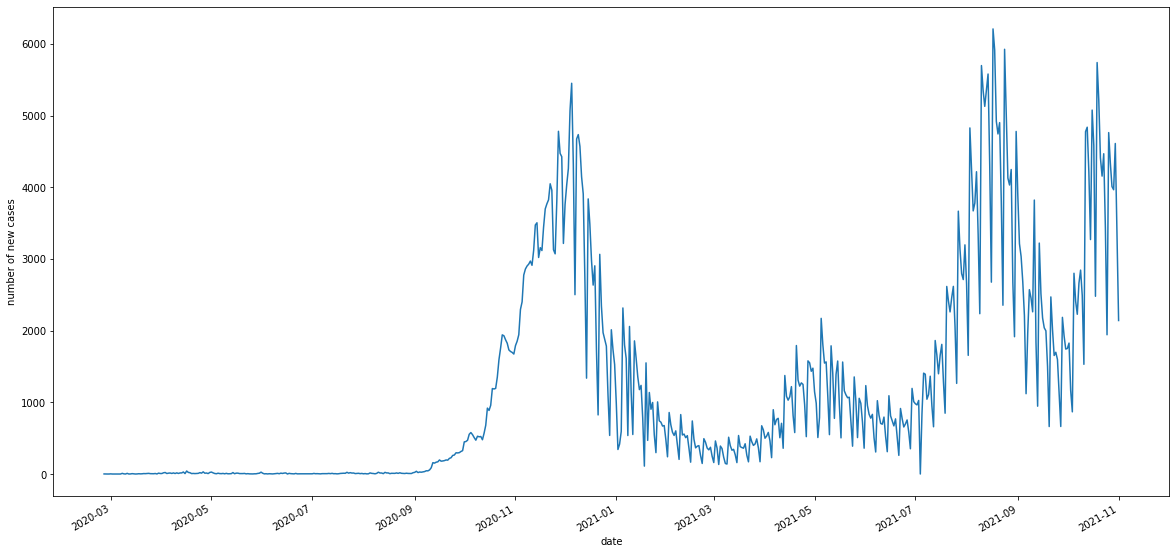

In [205]:
# plot time series
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20, 10))
plt.plot(date, new_cases)
plt.xlabel("date")
plt.ylabel("number of new cases")
fig.autofmt_xdate()
plt.show()


On weekends less covid tests are performed, which gives us weekly periodicity, we can check this by looking at frequency domain representation.

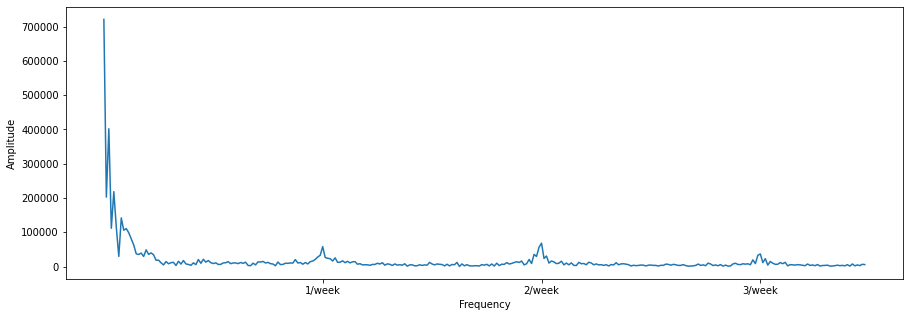

In [206]:
import tensorflow as tf
import numpy as np

new_cases_fft = tf.abs(tf.signal.fft(new_cases))
new_cases_fft = new_cases_fft[:int(len(new_cases)/2)]
freq_bins = np.arange(0, 0.5, 0.5/len(new_cases_fft))

week_freq_index = np.where(freq_bins >= 1/7)
week_freq_index = week_freq_index[0][0]

plt.figure(figsize = (15,5))
plt.plot(freq_bins, new_cases_fft)
plt.xticks(ticks = [freq_bins[week_freq_index], freq_bins[2*week_freq_index], freq_bins[3*week_freq_index]], labels = ["1/week", "2/week", "3/week"])
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

Because of this, it's good to have another feature that represents week day

In [207]:
# Create week day feature
week_day = np.array(list(map(lambda x: x.weekday(), date)))

week_day = tf.one_hot(week_day, depth = 7)

week_day[:10]

<tf.Tensor: shape=(10, 7), dtype=float32, numpy=
array([[0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.]], dtype=float32)>

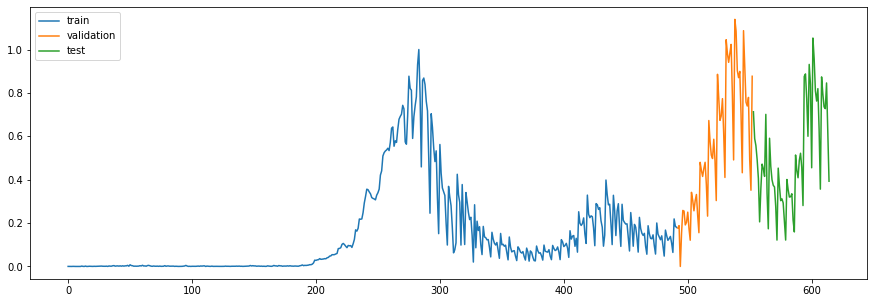

In [208]:
# Create train (80%), validation (10%) and test (10%) splits:
data_length = len(new_cases)
train_split_index = int(0.8 * data_length)
test_split_index = int(0.9 * data_length)

new_cases_train = new_cases[:train_split_index]
week_day_train = week_day[:train_split_index]

new_cases_valid = new_cases[train_split_index:test_split_index]
week_day_valid = week_day[train_split_index:test_split_index]

new_cases_test = new_cases[test_split_index:]
week_day_test = week_day[test_split_index:]

# normalize data
new_cases_max = np.max(new_cases_train)

new_cases_train = new_cases_train / new_cases_max
new_cases_test = new_cases_test / new_cases_max
new_cases_valid = new_cases_valid / new_cases_max

# Visualize train, validation and test splits

plt.figure(figsize = (15,5))
plt.plot(range(0,train_split_index), new_cases_train)
plt.plot(range(train_split_index, test_split_index), new_cases_valid)
plt.plot(range(test_split_index, data_length), new_cases_test)
plt.legend(["train", "validation", "test"])

# Baseline model: naive forecast

Create a model in which the forecast for the next day is equal to the value on the current day.

In [209]:
# create naive forecast model as a function
def naive_forecast(previous_day):
  next_day = previous_day
  return next_day

In [210]:
# make some predictions using naive forecast model
naive_forecast_inputs = new_cases_test[:-1]
naive_forecast_preds = naive_forecast(naive_forecast_inputs)
naive_forecast_labels = new_cases_test[1:]

In [211]:
# evaluate naive forecast model (mean absolute error, root mean squared error)
mae = tf.keras.metrics.mae(naive_forecast_labels,
                                            naive_forecast_preds).numpy()
mse =  tf.reduce_mean((naive_forecast_labels - naive_forecast_preds) ** 2).numpy()
naive_forecast_results = {"mae" : mae,
                          "mse" : mse}
naive_forecast_results

{'mae': 0.14627462776357344, 'mse': 0.04178977758951128}

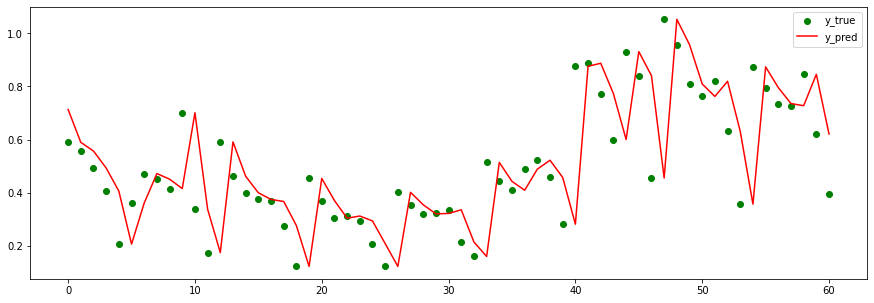

In [212]:
# plot naive forecast results

plt.figure(figsize = (15,5))
plt.plot(naive_forecast_labels,'go')
plt.plot(naive_forecast_preds, 'r-')
plt.legend(["y_true", "y_pred"])
plt.show()

# Prepare time series windows

We will be building models to predict new Covid cases based on last 6 days, so our data will have window size of 6 and horizon size of 1.

In [213]:
# create a function to generate time series windows
def generate_windows(data, window_size = 6):
  window_indices = range(0, len(data) - window_size)
  label_indices = range(window_size, len(data))
  
  windows = [data[index:(index + window_size)] for index in window_indices]
  labels = data[label_indices]

  return np.array(windows), np.array(labels)

In [214]:
new_cases_train_windows, new_cases_train_labels = generate_windows(new_cases_train)
new_cases_valid_windows, new_cases_valid_labels = generate_windows(new_cases_valid)
new_cases_test_windows, new_cases_test_labels = generate_windows(new_cases_test)

week_day_train_windows, _ = generate_windows(week_day_train.numpy())
week_day_valid_windows, _ = generate_windows(week_day_valid.numpy())
week_day_test_windows, _ = generate_windows(week_day_test.numpy())

# shuffle train data
random_indices = np.random.permutation(len(new_cases_train_windows))
new_cases_train_windows = new_cases_train_windows[random_indices]
new_cases_train_labels = new_cases_train_labels[random_indices]
week_day_train_windows = week_day_train_windows[random_indices]

print(len(new_cases_train_windows), len(new_cases_train_labels), 
      len(new_cases_valid_windows), len(new_cases_valid_labels), 
      len(new_cases_test_windows), len(new_cases_test_labels))

486 486 55 55 56 56


In [215]:
for n in range(1,5):
  print(f"data: {new_cases_test_windows[n]} label: {new_cases_test_labels[n]}")

data: [0.5893578  0.55669725 0.49247706 0.40550459 0.20550459 0.36055046] label: 0.47174311926605506
data: [0.55669725 0.49247706 0.40550459 0.20550459 0.36055046 0.47174312] label: 0.4504587155963303
data: [0.49247706 0.40550459 0.20550459 0.36055046 0.47174312 0.45045872] label: 0.415045871559633
data: [0.40550459 0.20550459 0.36055046 0.47174312 0.45045872 0.41504587] label: 0.7011009174311926


# First model: Multi-layer perceptron

Let's build a neural network model using dense layers

In [216]:
import tensorflow as tf

# build a model using Sequential API
model_dense_univariate = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dense(1, activation = None)
])

# compile the model
model_dense_univariate.compile(optimizer = tf.keras.optimizers.Adam(),
                               loss = tf.keras.losses.mae,
                               metrics = ["mae", "mse"])

# fit the model
model_dense_univariate.fit(new_cases_train_windows, new_cases_train_labels,
                           epochs = 5,
                           validation_data = (new_cases_valid_windows, new_cases_valid_labels))

Epoch 1/5
16/16 [==============================] - 1s 12ms/step - loss: 0.0698 - mae: 0.0698 - mse: 0.0173 - val_loss: 0.1458 - val_mae: 0.1458 - val_mse: 0.0353
Epoch 2/5
16/16 [==============================] - 0s 3ms/step - loss: 0.0326 - mae: 0.0326 - mse: 0.0040 - val_loss: 0.1320 - val_mae: 0.1320 - val_mse: 0.0339
Epoch 3/5
16/16 [==============================] - 0s 3ms/step - loss: 0.0316 - mae: 0.0316 - mse: 0.0038 - val_loss: 0.1355 - val_mae: 0.1355 - val_mse: 0.0336
Epoch 4/5
16/16 [==============================] - 0s 3ms/step - loss: 0.0305 - mae: 0.0305 - mse: 0.0038 - val_loss: 0.1370 - val_mae: 0.1370 - val_mse: 0.0340
Epoch 5/5
16/16 [==============================] - 0s 3ms/step - loss: 0.0299 - mae: 0.0299 - mse: 0.0038 - val_loss: 0.1387 - val_mae: 0.1387 - val_mse: 0.0346


In [217]:
dense_univariate_results = model_dense_univariate.evaluate(new_cases_test_windows,
                                  new_cases_test_labels)
dense_univariate_results

2/2 [==============================] - 0s 6ms/step - loss: 0.1267 - mae: 0.1267 - mse: 0.0307


[0.12671823799610138, 0.12671823799610138, 0.030701488256454468]

In [218]:
model_dense_univariate.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 64)                448       
_________________________________________________________________
dense_46 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 33        
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
_________________________________________________________________


In [219]:
# get model predictions
dense_univariate_preds = model_dense_univariate.predict(new_cases_test_windows)

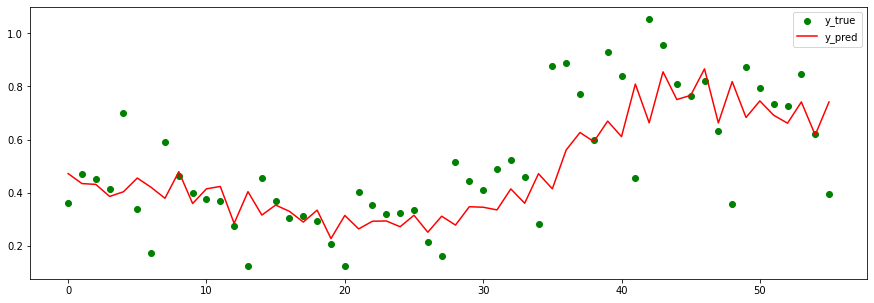

In [220]:
# plot model predictions

plt.figure(figsize = (15,5))
plt.plot(new_cases_test[6:],'go')
plt.plot(dense_univariate_preds, 'r-')
plt.legend(["y_true", "y_pred"])
plt.show()

# Model 2: Convolutional neural network

1 dimensional convolutional layers are good for sequence problems

In [221]:
# add an extra dimension, because conv1d layer requires 3-dimensional input
new_cases_train_windows_conv = tf.expand_dims(new_cases_train_windows, axis = -1)
new_cases_valid_windows_conv = tf.expand_dims(new_cases_valid_windows, axis = -1)
new_cases_test_windows_conv = tf.expand_dims(new_cases_test_windows, axis = -1)


# build a model using Sequential API
model_Conv1D_univariate = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 16, kernel_size = 3, activation = "relu", input_shape = (6, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dense(1, activation = None)
])

# compile the model
model_Conv1D_univariate.compile(optimizer = tf.keras.optimizers.Adam(),
                               loss = tf.keras.losses.mae,
                               metrics = ["mae", "mse"])

# fit the model
model_Conv1D_univariate.fit(new_cases_train_windows_conv, new_cases_train_labels,
                           epochs = 10,
                           validation_data = (new_cases_valid_windows_conv, new_cases_valid_labels))

Epoch 1/10
16/16 [==============================] - 1s 12ms/step - loss: 0.1384 - mae: 0.1384 - mse: 0.0638 - val_loss: 0.4877 - val_mae: 0.4877 - val_mse: 0.3051
Epoch 2/10
16/16 [==============================] - 0s 3ms/step - loss: 0.0851 - mae: 0.0851 - mse: 0.0277 - val_loss: 0.2513 - val_mae: 0.2513 - val_mse: 0.0974
Epoch 3/10
16/16 [==============================] - 0s 3ms/step - loss: 0.0452 - mae: 0.0452 - mse: 0.0073 - val_loss: 0.1352 - val_mae: 0.1352 - val_mse: 0.0329
Epoch 4/10
16/16 [==============================] - 0s 3ms/step - loss: 0.0367 - mae: 0.0367 - mse: 0.0048 - val_loss: 0.1516 - val_mae: 0.1516 - val_mse: 0.0366
Epoch 5/10
16/16 [==============================] - 0s 3ms/step - loss: 0.0349 - mae: 0.0349 - mse: 0.0043 - val_loss: 0.1361 - val_mae: 0.1361 - val_mse: 0.0333
Epoch 6/10
16/16 [==============================] - 0s 4ms/step - loss: 0.0342 - mae: 0.0342 - mse: 0.0047 - val_loss: 0.1396 - val_mae: 0.1396 - val_mse: 0.0337
Epoch 7/10
16/16 [=========

In [222]:
Conv1D_univariate_results = model_Conv1D_univariate.evaluate(new_cases_test_windows_conv, new_cases_test_labels)
Conv1D_univariate_results

2/2 [==============================] - 0s 7ms/step - loss: 0.1252 - mae: 0.1252 - mse: 0.0282


[0.12523379921913147, 0.12523379921913147, 0.028238704428076744]

In [223]:
model_Conv1D_univariate.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 4, 16)             64        
_________________________________________________________________
flatten_7 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 33        
Total params: 2,177
Trainable params: 2,177
Non-trainable params: 0
_________________________________________________________________


In [224]:
# get model predictions
Conv1D_univariate_preds = model_Conv1D_univariate.predict(new_cases_test_windows_conv)

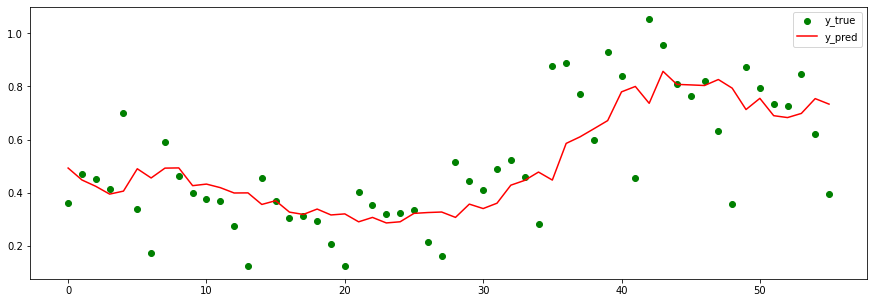

In [225]:
# plot model predictions

plt.figure(figsize = (15,5))
plt.plot(new_cases_test[6:],'go')
plt.plot(tf.squeeze(Conv1D_univariate_preds), 'r-')
plt.legend(["y_true", "y_pred"])
plt.show()

# Model 3: LSTM

let's try to use recurrent neural network

In [226]:
# build a model using Sequential API
model_LSTM_univariate = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation = "relu"),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dense(1, activation = None)
])

# compile the model
model_LSTM_univariate.compile(optimizer = tf.keras.optimizers.Adam(),
                               loss = tf.keras.losses.mae,
                               metrics = ["mae", "mse"])

# fit the model
model_LSTM_univariate.fit(new_cases_train_windows_conv, new_cases_train_labels,
                           epochs = 10,
                           validation_data = (new_cases_valid_windows_conv, new_cases_valid_labels))

Epoch 1/10
16/16 [==============================] - 2s 23ms/step - loss: 0.1181 - mae: 0.1181 - mse: 0.0449 - val_loss: 0.4126 - val_mae: 0.4126 - val_mse: 0.2312
Epoch 2/10
16/16 [==============================] - 0s 7ms/step - loss: 0.0727 - mae: 0.0727 - mse: 0.0182 - val_loss: 0.2223 - val_mae: 0.2223 - val_mse: 0.0740
Epoch 3/10
16/16 [==============================] - 0s 7ms/step - loss: 0.0412 - mae: 0.0412 - mse: 0.0050 - val_loss: 0.1489 - val_mae: 0.1489 - val_mse: 0.0391
Epoch 4/10
16/16 [==============================] - 0s 7ms/step - loss: 0.0357 - mae: 0.0357 - mse: 0.0045 - val_loss: 0.1505 - val_mae: 0.1505 - val_mse: 0.0388
Epoch 5/10
16/16 [==============================] - 0s 7ms/step - loss: 0.0344 - mae: 0.0344 - mse: 0.0044 - val_loss: 0.1518 - val_mae: 0.1518 - val_mse: 0.0395
Epoch 6/10
16/16 [==============================] - 0s 7ms/step - loss: 0.0345 - mae: 0.0345 - mse: 0.0043 - val_loss: 0.1525 - val_mae: 0.1525 - val_mse: 0.0397
Epoch 7/10
16/16 [=========

In [227]:
model_LSTM_univariate.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 64)                16896     
_________________________________________________________________
dense_50 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 33        
Total params: 19,009
Trainable params: 19,009
Non-trainable params: 0
_________________________________________________________________


In [228]:
LSTM_univariate_results = model_LSTM_univariate.evaluate(new_cases_test_windows_conv, new_cases_test_labels)
LSTM_univariate_results

2/2 [==============================] - 0s 6ms/step - loss: 0.1396 - mae: 0.1396 - mse: 0.0334


[0.13957814872264862, 0.13957814872264862, 0.03340578451752663]

In [229]:
# get model predictions
LSTM_univariate_preds = model_LSTM_univariate.predict(new_cases_test_windows_conv)

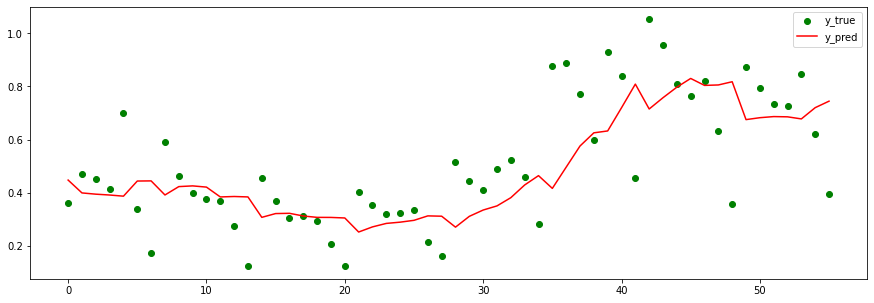

In [230]:
# plot model predictions

plt.figure(figsize = (15,5))
plt.plot(new_cases_test[6:],'go')
plt.plot(tf.squeeze(LSTM_univariate_preds), 'r-')
plt.legend(["y_true", "y_pred"])
plt.show()

# Create multivariate models

Include day of week feature in data.

In [231]:
# add day of week features to windows
new_cases_week_train = np.concatenate((new_cases_train_windows_conv, week_day_train_windows), axis = 2)
new_cases_week_valid = np.concatenate((new_cases_valid_windows_conv, week_day_valid_windows), axis = 2)
new_cases_week_test = np.concatenate((new_cases_test_windows_conv, week_day_test_windows), axis = 2)

new_cases_week_train[:2]

array([[[0.09559633, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 1.        ],
        [0.04770642, 1.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.16770642, 0.        , 1.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.14183486, 0.        , 0.        , 1.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.12036697, 0.        , 0.        , 0.        , 1.        ,
         0.        , 0.        , 0.        ],
        [0.12825688, 0.        , 0.        , 0.        , 0.        ,
         1.        , 0.        , 0.        ]],

       [[0.00183486, 1.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.00146789, 0.        , 1.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.0012844 , 0.        , 0.        , 1.        , 0.        ,
         

In [232]:
# create datasets using tf.data.dataset

train_data = tf.data.Dataset.from_tensor_slices(new_cases_week_train)
train_labels = tf.data.Dataset.from_tensor_slices(new_cases_train_labels)
train_dataset = tf.data.Dataset.zip((train_data, train_labels))

train_dataset = train_dataset.batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

valid_data = tf.data.Dataset.from_tensor_slices(new_cases_week_valid)
valid_labels = tf.data.Dataset.from_tensor_slices(new_cases_valid_labels)
valid_dataset = tf.data.Dataset.zip((valid_data, valid_labels))

valid_dataset = valid_dataset.batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

test_data = tf.data.Dataset.from_tensor_slices(new_cases_week_test)
test_labels = tf.data.Dataset.from_tensor_slices(new_cases_test_labels)
test_dataset = tf.data.Dataset.zip((test_data, test_labels))

test_dataset = test_dataset.batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)


Model 1: dense layers only

In [233]:
# build a model using Sequential API
model_dense_multivariate = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dense(1, activation = None)
])

# compile the model
model_dense_multivariate.compile(optimizer = tf.keras.optimizers.Adam(),
                               loss = tf.keras.losses.mae,
                               metrics = ["mae", "mse"])

# fit the model
model_dense_multivariate.fit(train_dataset,
                           epochs = 5,
                           validation_data = valid_dataset)

Epoch 1/5
16/16 [==============================] - 1s 9ms/step - loss: 0.0900 - mae: 0.0900 - mse: 0.0179 - val_loss: 0.2197 - val_mae: 0.2197 - val_mse: 0.0694
Epoch 2/5
16/16 [==============================] - 0s 3ms/step - loss: 0.0545 - mae: 0.0545 - mse: 0.0069 - val_loss: 0.1482 - val_mae: 0.1482 - val_mse: 0.0362
Epoch 3/5
16/16 [==============================] - 0s 3ms/step - loss: 0.0388 - mae: 0.0388 - mse: 0.0038 - val_loss: 0.1183 - val_mae: 0.1183 - val_mse: 0.0251
Epoch 4/5
16/16 [==============================] - 0s 3ms/step - loss: 0.0329 - mae: 0.0329 - mse: 0.0030 - val_loss: 0.1098 - val_mae: 0.1098 - val_mse: 0.0206
Epoch 5/5
16/16 [==============================] - 0s 3ms/step - loss: 0.0318 - mae: 0.0318 - mse: 0.0031 - val_loss: 0.1130 - val_mae: 0.1130 - val_mse: 0.0211


In [234]:
dense_multivariate_results = model_dense_multivariate.evaluate(test_dataset)

2/2 [==============================] - 0s 6ms/step - loss: 0.0949 - mae: 0.0949 - mse: 0.0170


In [235]:
model_dense_multivariate.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 48)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 64)                3136      
_________________________________________________________________
dense_53 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 33        
Total params: 5,249
Trainable params: 5,249
Non-trainable params: 0
_________________________________________________________________


In [236]:
dense_multivariate_preds = model_dense_multivariate.predict(test_dataset)

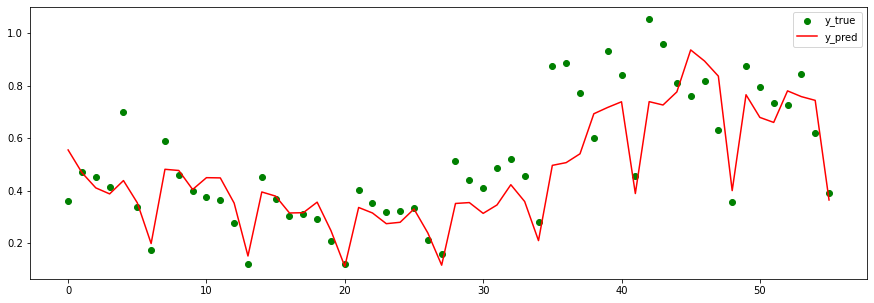

In [237]:
# plot model predictions

plt.figure(figsize = (15,5))
plt.plot(new_cases_test[6:],'go')
plt.plot(tf.squeeze(dense_multivariate_preds), 'r-')
plt.legend(["y_true", "y_pred"])
plt.show()

Model 2: convolutional neural network

In [238]:
# build a model using Sequential API
model_Conv1D_multivariate = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 16, kernel_size = 3, activation = "relu", input_shape = (6, 8)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dense(1, activation = None)
])

# compile the model
model_Conv1D_multivariate.compile(optimizer = tf.keras.optimizers.Adam(),
                               loss = tf.keras.losses.mae,
                               metrics = ["mae", "mse"])

# fit the model
model_Conv1D_multivariate.fit(train_dataset,
                              epochs = 15,
                              validation_data = valid_dataset)

Epoch 1/15
16/16 [==============================] - 1s 9ms/step - loss: 0.2115 - mae: 0.2115 - mse: 0.0887 - val_loss: 0.4984 - val_mae: 0.4984 - val_mse: 0.3303
Epoch 2/15
16/16 [==============================] - 0s 2ms/step - loss: 0.1333 - mae: 0.1333 - mse: 0.0434 - val_loss: 0.5110 - val_mae: 0.5110 - val_mse: 0.3292
Epoch 3/15
16/16 [==============================] - 0s 2ms/step - loss: 0.1094 - mae: 0.1094 - mse: 0.0327 - val_loss: 0.4037 - val_mae: 0.4037 - val_mse: 0.2131
Epoch 4/15
16/16 [==============================] - 0s 3ms/step - loss: 0.0810 - mae: 0.0810 - mse: 0.0194 - val_loss: 0.2940 - val_mae: 0.2940 - val_mse: 0.1163
Epoch 5/15
16/16 [==============================] - 0s 2ms/step - loss: 0.0535 - mae: 0.0535 - mse: 0.0089 - val_loss: 0.1475 - val_mae: 0.1475 - val_mse: 0.0355
Epoch 6/15
16/16 [==============================] - 0s 2ms/step - loss: 0.0368 - mae: 0.0368 - mse: 0.0043 - val_loss: 0.1023 - val_mae: 0.1023 - val_mse: 0.0163
Epoch 7/15
16/16 [==========

In [239]:
Conv1D_multivariate_results = model_Conv1D_multivariate.evaluate(test_dataset)

2/2 [==============================] - 0s 4ms/step - loss: 0.0942 - mae: 0.0942 - mse: 0.0161


In [240]:
model_Conv1D_multivariate.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 4, 16)             400       
_________________________________________________________________
flatten_9 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 33        
Total params: 2,513
Trainable params: 2,513
Non-trainable params: 0
_________________________________________________________________


In [241]:
Conv1D_multivariate_preds = model_Conv1D_multivariate.predict(test_dataset)

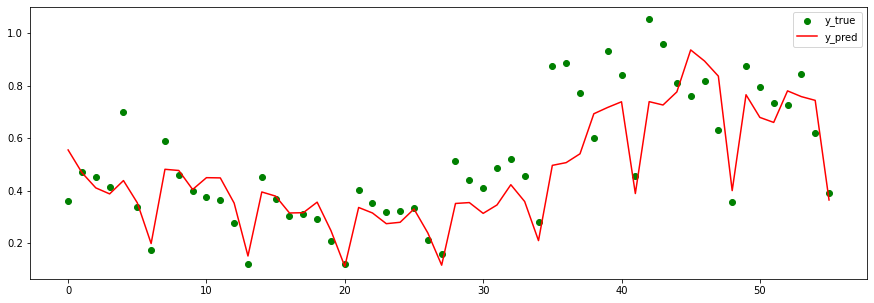

In [242]:
# plot model predictions

plt.figure(figsize = (15,5))
plt.plot(new_cases_test[6:],'go')
plt.plot(tf.squeeze(dense_multivariate_preds), 'r-')
plt.legend(["y_true", "y_pred"])
plt.show()

Model 3: Recurrent Neural Network

In [243]:
# build a model using Sequential API
model_LSTM_multivariate = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation = "relu"),
    tf.keras.layers.Dense(32, activation = "relu"),
    tf.keras.layers.Dense(1, activation = None)
])

# compile the model
model_LSTM_multivariate.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
                               loss = tf.keras.losses.mae,
                               metrics = ["mae", "mse"])

# fit the model
model_LSTM_multivariate.fit(train_dataset,
                           epochs = 15,
                           validation_data = valid_dataset)

Epoch 1/15
16/16 [==============================] - 2s 22ms/step - loss: 0.0965 - mae: 0.0965 - mse: 0.0249 - val_loss: 0.1803 - val_mae: 0.1803 - val_mse: 0.0467
Epoch 2/15
16/16 [==============================] - 0s 7ms/step - loss: 0.0580 - mae: 0.0580 - mse: 0.0068 - val_loss: 0.1400 - val_mae: 0.1400 - val_mse: 0.0320
Epoch 3/15
16/16 [==============================] - 0s 6ms/step - loss: 0.0380 - mae: 0.0380 - mse: 0.0036 - val_loss: 0.1199 - val_mae: 0.1199 - val_mse: 0.0257
Epoch 4/15
16/16 [==============================] - 0s 7ms/step - loss: 0.0311 - mae: 0.0311 - mse: 0.0029 - val_loss: 0.1223 - val_mae: 0.1223 - val_mse: 0.0254
Epoch 5/15
16/16 [==============================] - 0s 6ms/step - loss: 0.0338 - mae: 0.0338 - mse: 0.0033 - val_loss: 0.1010 - val_mae: 0.1010 - val_mse: 0.0176
Epoch 6/15
16/16 [==============================] - 0s 7ms/step - loss: 0.0310 - mae: 0.0310 - mse: 0.0028 - val_loss: 0.1215 - val_mae: 0.1215 - val_mse: 0.0247
Epoch 7/15
16/16 [=========

In [244]:
LSTM_multivariate_results = model_LSTM_multivariate.evaluate(test_dataset)

2/2 [==============================] - 0s 8ms/step - loss: 0.0900 - mae: 0.0900 - mse: 0.0159


In [245]:
model_LSTM_multivariate.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 64)                18688     
_________________________________________________________________
dense_57 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 33        
Total params: 20,801
Trainable params: 20,801
Non-trainable params: 0
_________________________________________________________________


In [246]:
LSTM_multivariate_preds = model_LSTM_multivariate.predict(test_dataset)

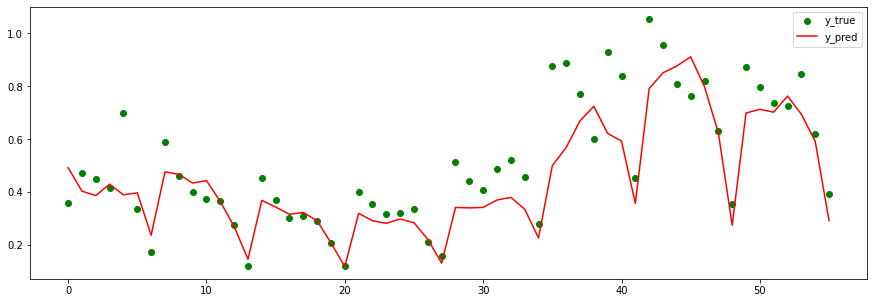

In [247]:
# plot model predictions

plt.figure(figsize = (15,5))
plt.plot(new_cases_test[6:],'go')
plt.plot(tf.squeeze(LSTM_multivariate_preds), 'r-')
plt.legend(["y_true", "y_pred"])
plt.show()

# Compare model results

Plot all results and choose the best performing model.

In [248]:
dense_univariate_results[2]

0.030701488256454468

Text(0, 0.5, 'mse')

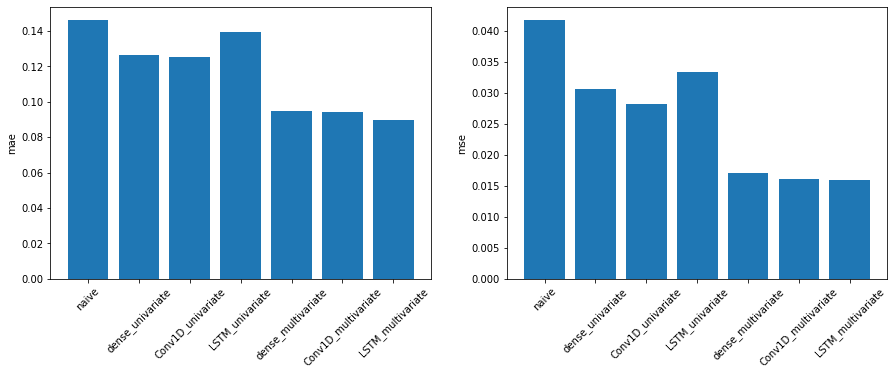

In [249]:
# plot results of all models

mae_results = {"naive" : naive_forecast_results["mae"],
               "dense_univariate" : dense_univariate_results[1],
               "Conv1D_univariate" : Conv1D_univariate_results[1],
               "LSTM_univariate" : LSTM_univariate_results[1],
               "dense_multivariate" : dense_multivariate_results[1],
               "Conv1D_multivariate" : Conv1D_multivariate_results[1],
               "LSTM_multivariate" : LSTM_multivariate_results[1]}

mse_results = {"naive" : naive_forecast_results["mse"],
               "dense_univariate" : dense_univariate_results[2],
               "Conv1D_univariate" : Conv1D_univariate_results[2],
               "LSTM_univariate" : LSTM_univariate_results[2],
               "dense_multivariate" : dense_multivariate_results[2],
               "Conv1D_multivariate" : Conv1D_multivariate_results[2],
               "LSTM_multivariate" : LSTM_multivariate_results[2]}

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.bar(x = mae_results.keys(), height = mae_results.values())
plt.xticks(rotation = 45)
plt.ylabel("mae")
plt.subplot(1,2,2)
plt.bar(x = mse_results.keys(), height = mse_results.values())
plt.xticks(rotation = 45)
plt.ylabel("mse")

Looks like LSTM model with multivariate input got the best results

# Predict next day

Use the best model to estimate number of positive Covid-19 cases tomorrow.

In [250]:
data_for_tomorrow = np.concatenate((np.expand_dims(new_cases[-6:]/new_cases_max, axis = 1), week_day[-6:]), axis = 1)
prediction_for_tomorrow = tf.squeeze(new_cases_max * model_LSTM_multivariate.predict(tf.expand_dims(data_for_tomorrow, axis = 0)))

print(f"Today is {date[-1]}.\nestimated number of new Covid_19 cases for {date[-1] + datetime.timedelta(days = 1)} is {int(prediction_for_tomorrow)})")

Today is 2021-11-01.
estimated number of new Covid_19 cases for 2021-11-02 is 3828)
